In [1]:
# import os
# import tensorflow as tf

# # Set CUDA device order and visible devices
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# # Set the device
# device = '/cpu:0'
# if tf.config.experimental.list_physical_devices('GPU'):
#     try:
#         # Restrict TensorFlow to only use the second GPU
#         gpus = tf.config.experimental.list_physical_devices('GPU')
#         if gpus:
#             tf.config.experimental.set_visible_devices(gpus[9], 'GPU')
#             device = '/gpu:9'
#     except RuntimeError as e:
#         print(e)

# print("device", device)


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"  # Only GPUs 0 and 1 will be visible to TensorFlow

import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1","/gpu:2"])

2024-09-19 21:06:11.764850: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-19 21:06:11.777087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 21:06:11.789572: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 21:06:11.793373: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 21:06:11.803781: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


2024-09-19 21:06:14.186119: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:45:00.0, compute capability: 8.0
2024-09-19 21:06:14.187580: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79196 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:46:00.0, compute capability: 8.0
2024-09-19 21:06:14.188921: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79196 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:49:00.0, compute capability: 8.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks


In [3]:

# -----------------------------
# DataLoader Class Definition
# -----------------------------
class DataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'])
            centers = np.array(f['centers_training'])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='x')  # center[1] is x and center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        normalized_centers = sorted_centers / 64

        normalized_midpoints = tf.expand_dims(normalized_centers, axis=1)
        return normalized_images, normalized_midpoints.numpy()

    def split_data(self, train_size=0.8, random_state=42):
        normalized_images, normalized_midpoints_np = self.normalize_data()
        return train_test_split(normalized_images, normalized_midpoints_np, train_size=train_size, random_state=random_state)


In [4]:

# -----------------------------
# Utility Function Definition
# -----------------------------
def plot_transposed_images_with_midpoints(dataset, image_indices=[0, 1, 2, 3]):
    """
    Extracts multiple images and their midpoints from the given dataset, transposes the images, 
    corrects the midpoints, and plots the transposed images with the corrected midpoints.

    Args:
    - dataset (tf.data.Dataset): The dataset from which to extract the images and midpoints.
    - image_indices (list): The indices of the images in the batch to visualize. Default is [0, 1, 2, 3].
    """

    # Extract a sample image batch and its corresponding midpoints from the dataset
    sample_image_batch, sample_midpoints_batch = next(iter(dataset))

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(image_indices):
            # Select the specified image and corresponding midpoints from the batch
            sample_image = np.array(sample_image_batch[image_indices[i]])
            sample_midpoints = np.array(sample_midpoints_batch[image_indices[i]])

            # Transpose the image
            transposed_image = sample_image.T

            # Correct the midpoints by swapping the x and y coordinates
            transposed_midpoints_corrected = sample_midpoints[:, :, [1, 0]]

            # Plot the transposed image with corrected midpoints
            ax.imshow(transposed_image, cmap='gray')
            ax.scatter(
                transposed_midpoints_corrected[:, :, 0] * 64, 
                transposed_midpoints_corrected[:, :, 1] * 64, 
                c='red', marker='o', s=5
            )
            ax.set_title(f'Image {image_indices[i]} for this batch')
        else:
            ax.axis('off')  # If fewer than 4 images are requested, hide the unused subplots

    plt.tight_layout()
    plt.show()

# -----------------------------
# Custom Loss and Callback Definitions
# -----------------------------
@tf.keras.utils.register_keras_serializable()
def custom_loss(exponent):
    def loss(y_true, y_pred):
        diff = tf.abs(y_true - y_pred)
        powered_diff = tf.pow(diff, exponent)
        return tf.reduce_mean(powered_diff)
    return loss

@tf.keras.utils.register_keras_serializable()
class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent, increment, update_frequency):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'initial_exponent': self.exponent,
            'increment': self.increment,
            'update_frequency': self.update_frequency,
        })
        return config


My model

In [5]:
# class ModelBuilder:
#     def __init__(self, input_shape=(64, 64, 1), num_classes=5, num_coordinates=2, learning_rate=1e-3, weights_path=None):
#         self.input_shape = input_shape
#         self.num_classes = num_classes
#         self.num_coordinates = num_coordinates
#         self.learning_rate = learning_rate
#         self.model = self.build_model()

#         # Load weights if a path is provided
#         if weights_path is not None:
#             self.model.load_weights(weights_path)

#         self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
#         # self.optimizer =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

#     def build_model(self):
#         x_input = layers.Input(shape=self.input_shape)
#         x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
#         x = layers.MaxPool2D()(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
        
#         x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Dropout(0.05)(x)
#         x = layers.BatchNormalization()(x)
        
        
#         x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Dropout(0.05)(x)
#         x = layers.BatchNormalization()(x)
        
        
#         x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.Dropout(0.1)(x)
#         x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.Dropout(0.1)(x)
        
#         x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.BatchNormalization()(x)
#         # x = layers.Dropout(0.1)(x)
        
#         x = layers.Flatten()(x)
        
        
        
#         x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
#         x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
#         return tf.keras.models.Model(x_input, x_midpoints_reshape)

#     def compile_model(self, loss_function):
#         self.model.compile(optimizer=self.optimizer, loss=loss_function)

#     def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
#         history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
#         return history


Josh's model

In [6]:
class ModelBuilder:
    def __init__(self, input_shape=(64, 64, 1), num_classes=5, num_coordinates=2, learning_rate=1e-2, weights_path=None):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.model = self.build_model()

        # Load weights if a path is provided
        if weights_path is not None:
            self.model.load_weights(weights_path)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # self.optimizer =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

    def build_model(self):
        x_input = layers.Input(shape=self.input_shape)
        
        x_1 = layers.Conv2D(32, kernel_size=6, padding='same', activation='relu')(x_input)
        x_2 = layers.Conv2D(32, kernel_size=8, padding='same', activation='relu')(x_input)
        x_3 = layers.Conv2D(64, kernel_size=19, padding='same', activation='relu')(x_input)
        
        x = layers.concatenate([x_1, x_2, x_3])
        x = layers.Flatten()(x)
               
        x = layers.Dense(64, activation='relu')(x)
        # x = layers.Dropout(0.1)(x)
        x = layers.Dense(32, activation='relu')(x)
        # x = layers.Dropout(0.1)(x)
        x = layers.Dense(16, activation='relu')(x)
        
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


In [7]:

# -----------------------------
# Main Script Execution
# -----------------------------

# Load data
h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KPadded_Mixed_5.h5'             

data_loader = DataLoader(h5_filename)
images, centers = data_loader.load_data()


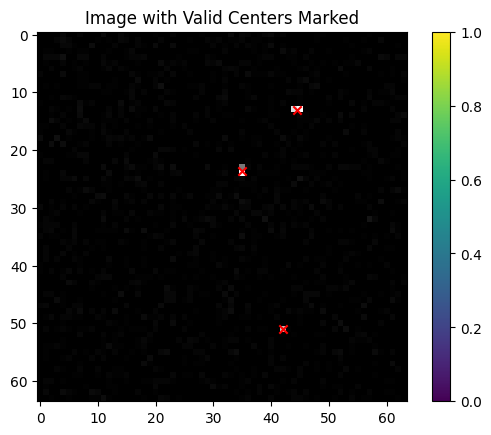

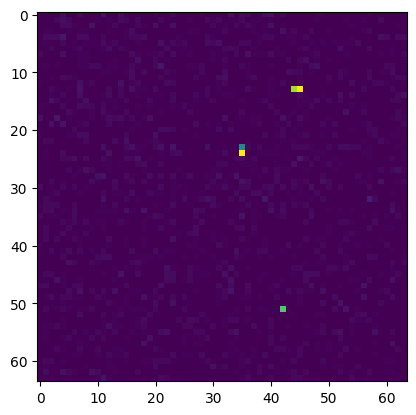

In [10]:
l=np.random.randint(0,len(centers))
data_loader.plot_image_with_centers(l)
plt.imshow(images[l])

In [11]:

# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))


In [12]:

batch_size = 1000
train_dataset = train_dataset.shuffle(buffer_size=8000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=8000).batch(batch_size)

# Check the shape of the datasets
print(f'Train Images: {train_images.shape}, Train Midpoints: {train_midpoints.shape}')
print(f'Validation Images: {val_images.shape}, Validation Midpoints: {val_midpoints.shape}')


Train Images: (24000, 64, 64), Train Midpoints: (24000, 1, 5, 2)
Validation Images: (6000, 64, 64), Validation Midpoints: (6000, 1, 5, 2)


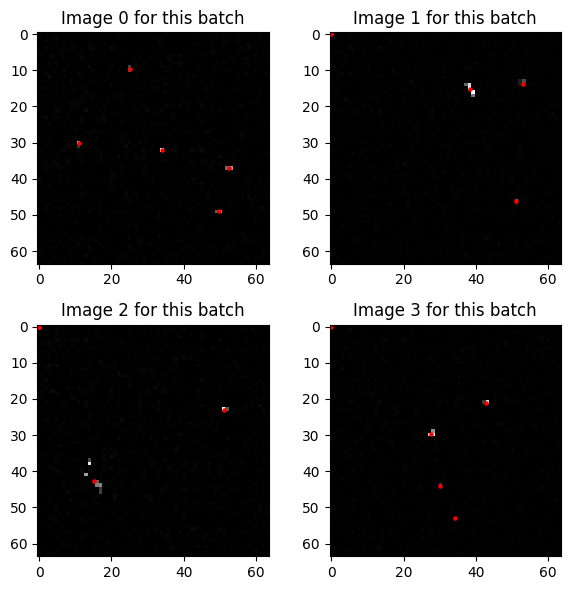

In [13]:
plot_transposed_images_with_midpoints(train_dataset, image_indices=[0, 1, 2, 3])

In [14]:


# Set up learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=5, verbose=1, mode='min', min_lr=7e-8
)


In [11]:
# import tensorflow as tf
##### used this initially 
# class DynamicHuberLoss(tf.keras.losses.Loss):
#     def __init__(self, initial_delta, final_delta, total_epochs, **kwargs):
#         super().__init__(**kwargs)
#         self.initial_delta = initial_delta
#         self.final_delta = final_delta
#         self.total_epochs = total_epochs
#         self.current_epoch = 0

#     def call(self, y_true, y_pred):
#         # Compute current delta
#         delta = self.initial_delta - ((self.initial_delta - self.final_delta) * (self.current_epoch / self.total_epochs))
#         # Compute Huber loss with current delta
#         return tf.keras.losses.huber(y_true, y_pred, delta=delta)

#     def update_epoch(self, epoch):
#         self.current_epoch = epoch

class DynamicHuberLoss(tf.keras.losses.Loss):
    def __init__(self, initial_delta=1.0, final_delta=0.5, total_epochs=450, **kwargs):
        super().__init__(**kwargs)
        self.initial_delta = initial_delta
        self.final_delta = final_delta
        self.total_epochs = total_epochs
        self.current_epoch = 0

    def call(self, y_true, y_pred):
        # Dynamically adjust delta based on the current epoch
        delta = self.initial_delta - ((self.initial_delta - self.final_delta) * (self.current_epoch / self.total_epochs))
        error = y_true - y_pred
        abs_error = tf.abs(error)
        quadratic = tf.minimum(abs_error, delta)
        linear = abs_error - quadratic
        loss = 0.5 * quadratic**2 + delta * linear
        return tf.reduce_mean(loss)

    def update_epoch(self, epoch):
        self.current_epoch = epoch

In [12]:
# Instantiate the dynamic Huber loss
dynamic_huber_loss = DynamicHuberLoss(initial_delta=1.0, final_delta=0.5, total_epochs=450)



# Create a custom callback to update the epoch
class UpdateEpochCallback(tf.keras.callbacks.Callback):
    def __init__(self, loss_fn):
        super().__init__()
        self.loss_fn = loss_fn
        self.current_epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.loss_fn.update_epoch(epoch)

# Instantiate the callback
update_epoch_callback = UpdateEpochCallback(dynamic_huber_loss)



In [15]:

# Initialize the ModelBuilder within the strategy scope
with strategy.scope():
    # Instantiate the model builder
    model_builder = ModelBuilder()

    # Build the model
    model_builder.build_model()

    # Display the model architecture
    model_builder.model.summary()

    # Compile the model
    model_builder.compile_model(loss_function=tf.keras.losses.Huber(delta=0.5))
    # model_builder.compile_model(loss_function=tf.keras.losses.MeanSquaredError())
    # If using a custom loss function, replace the above line with:
    # model_builder.compile_model(loss_function=custom_loss(exponent=2))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,184 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      2,080 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     23,168 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 128)              │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 524288)    │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │ 33,554,496 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_midpoints (Dense) │ (None, 10)        │        170 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_midpoints_reshape │ (None, 1, 5, 2)   │          0 │ x_midpoints[0][0] │
│ (Reshape)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,583,706 (128.11 MB)

 Trainable params: 33,583,706 (128.11 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:

# Train the model
history = model_builder.train_model(
    train_dataset, 
    val_dataset, 
    epochs=450,
    callbacks_list=[lr_scheduler]
)


Epoch 1/450


2024-09-19 21:08:07.244542: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-19 21:08:07.259062: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-19 21:08:07.293858: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1726780087.323105 3611054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726780087.328582 3611059 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726780087.342772 3611058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726780087.380735 3611054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726780087.380945 3611059 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726780087.380899 3611058 gpu_timer.c

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0553

2024-09-19 21:08:09.830329: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-09-19 21:08:09.830411: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-09-19 21:08:09.830587: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
W0000 00:00:1726780090.343892 3611057 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726780090.344107 3611051 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726780090.348901 3611051 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0542 - val_loss: 0.0286 - learning_rate: 0.0100
Epoch 2/450


W0000 00:00:1726780090.755840 3611051 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726780090.759211 3611057 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726780090.759302 3611068 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
2024-09-19 21:08:10.840407: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0275

2024-09-19 21:08:11.981577: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0275 - val_loss: 0.0222 - learning_rate: 0.0100
Epoch 3/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0239 - val_loss: 0.0184 - learning_rate: 0.0100
Epoch 4/450


2024-09-19 21:08:13.632251: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0197 - val_loss: 0.0165 - learning_rate: 0.0100
Epoch 5/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0178 - val_loss: 0.0168 - learning_rate: 0.0100
Epoch 6/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0159

2024-09-19 21:08:17.494796: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0158 - val_loss: 0.0155 - learning_rate: 0.0100
Epoch 7/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0153 - val_loss: 0.0165 - learning_rate: 0.0100
Epoch 8/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0143 - val_loss: 0.0154 - learning_rate: 0.0100
Epoch 9/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0138 - val_loss: 0.0153 - learning_rate: 0.0100
Epoch 10/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0134 - val_loss: 0.0149 - learning_rate: 0.0100
Epoch 11/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0128 - val_loss: 0.0148 - learning_rate: 0.0100
Epoch 12/450


2024-09-19 21:08:24.810356: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0128 - val_loss: 0.0162 - learning_rate: 0.0100
Epoch 13/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0124 - val_loss: 0.0148 - learning_rate: 0.0100
Epoch 14/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0119 - val_loss: 0.0149 - learning_rate: 0.0100
Epoch 15/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0116 - val_loss: 0.0152 - learning_rate: 0.0100
Epoch 16/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0113 - val_loss: 0.0154 - learning_rate: 0.0100
Epoch 17/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0108 - val_loss: 0.0152 - learning_rate: 0.0100
Epoch 18/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0107 - val_loss: 0.0155 - learning_rate: 0.0100
Epoch 19/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0106 - val_loss: 0.0152 - learning_rate: 0.0100
Epoch 20/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0103 - val_loss: 0.0155 - learning_rate: 0.0100
Epoch 21/450
2

2024-09-19 21:08:41.184228: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0099 - val_loss: 0.0156 - learning_rate: 0.0090
Epoch 23/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0095 - val_loss: 0.0157 - learning_rate: 0.0090
Epoch 24/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0093 - val_loss: 0.0150 - learning_rate: 0.0090
Epoch 25/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0091 - val_loss: 0.0160 - learning_rate: 0.0090
Epoch 26/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0091 - val_loss: 0.0160 - learning_rate: 0.0090
Epoch 27/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0089 - val_loss: 0.0155 - learning_rate: 0.0090
Epoch 28/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0085 - val_loss: 0.0158 - learning_rate: 0.0090
Epoch 29/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0084 - val_loss: 0.0162 - learning_rate: 0.0090
Epoch 30/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0084 - val_loss: 0.0162 - learning_rate: 0.0090
Epoch 31/450
2

2024-09-19 21:09:11.211640: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0067 - val_loss: 0.0170 - learning_rate: 0.0073
Epoch 45/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0065 - val_loss: 0.0175 - learning_rate: 0.0073
Epoch 46/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0064 - val_loss: 0.0170 - learning_rate: 0.0073
Epoch 47/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0064 - val_loss: 0.0170 - learning_rate: 0.0073
Epoch 48/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0063 - val_loss: 0.0170 - learning_rate: 0.0073
Epoch 49/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0062 - val_loss: 0.0173 - learning_rate: 0.0073
Epoch 50/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0062 - val_loss: 0.0171 - learning_rate: 0.0073
Epoch 51/450
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0061
Epoch 51: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0061 - val_loss: 0.0173 - learning_rate: 0

2024-09-19 21:10:11.374546: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0044 - val_loss: 0.0191 - learning_rate: 0.0048
Epoch 87/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0043 - val_loss: 0.0179 - learning_rate: 0.0048
Epoch 88/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0043 - val_loss: 0.0183 - learning_rate: 0.0048
Epoch 89/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0043 - val_loss: 0.0178 - learning_rate: 0.0048
Epoch 90/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0042 - val_loss: 0.0188 - learning_rate: 0.0048
Epoch 91/450
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0042
Epoch 91: ReduceLROnPlateau reducing learning rate to 0.0043046717997640375.
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0042 - val_loss: 0.0190 - learning_rate: 0.0048
Epoch 92/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0042 - val_loss: 0.0189 - learning_rate: 0.0043
Epoch 93/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0041 - val_loss: 0.0188 - learning_rate: 

2024-09-19 21:12:08.527681: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0028 - val_loss: 0.0206 - learning_rate: 0.0019
Epoch 173/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0028 - val_loss: 0.0209 - learning_rate: 0.0019
Epoch 174/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0027 - val_loss: 0.0198 - learning_rate: 0.0019
Epoch 175/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0028 - val_loss: 0.0204 - learning_rate: 0.0019
Epoch 176/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0028 - val_loss: 0.0203 - learning_rate: 0.0019
Epoch 177/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0027 - val_loss: 0.0209 - learning_rate: 0.0019
Epoch 178/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0027 - val_loss: 0.0203 - learning_rate: 0.0019
Epoch 179/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0027 - val_loss: 0.0208 - learning_rate: 0.0019
Epoch 180/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0027 - val_loss: 0.0204 - learning_rate: 0.0019
Epoch 

2024-09-19 21:16:00.501736: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0020 - val_loss: 0.0222 - learning_rate: 3.0903e-04
Epoch 344/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0020 - val_loss: 0.0214 - learning_rate: 3.0903e-04
Epoch 345/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0020 - val_loss: 0.0219 - learning_rate: 3.0903e-04
Epoch 346/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0020 - val_loss: 0.0209 - learning_rate: 3.0903e-04
Epoch 347/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0020 - val_loss: 0.0215 - learning_rate: 3.0903e-04
Epoch 348/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0020 - val_loss: 0.0220 - learning_rate: 3.0903e-04
Epoch 349/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0020 - val_loss: 0.0220 - learning_rate: 3.0903e-04
Epoch 350/450
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0020 - val_loss: 0.0220 - learning_rate: 3.0903e-04
Epoch 351/450
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0020
Epoch 351: Reduce

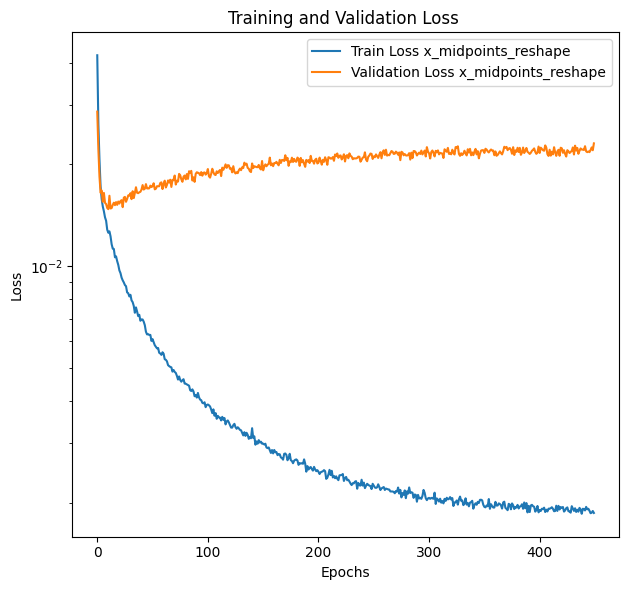

In [18]:


# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
# loaded_model = tf.keras.models.load_model(
#     "/home/da886/Electron Counting Extended Arch/Weights For Classes/3onlymixed.keras",safe_mode=False,
#     custom_objects={'DynamicExponentCallback': DynamicExponentCallback, 'custom_loss': custom_loss}
# )


/home/da886/anaconda3/envs/objectdetection/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 38 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [36]:
model_builder.model.save('/home/da886/Final Electron counting project/Experimental weights/JoshHuber5fixed.keras')

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the function for visualizing midpoints
def visualize_midpoints(image, midpoints, title="Predicted Midpoint Visualization"):
    """
    Visualizes midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - title: The title of the plot.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title(title)

    # Plot midpoints directly, only if they are not (0, 0)
    for i, (x, y) in enumerate(midpoints_np):
        if x >= 3 and y >= 3:  # Only plot if the point is not (0, 0)
            plt.scatter(x, y, color='red', s=5)

    plt.show()

# Create the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
val_dataset = val_dataset.batch(800)
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(800)

# Initialize lists to collect the data
all_images = []
all_true_midpoints = []
all_pred_midpoints = []

# Loop through each batch in the validation dataset, predict, and collect results
for i, (data_batch, midpoints_batch) in enumerate(val_dataset):

# for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
    print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
    # Get the model predictions
    predictions = model_builder.model.predict(data_batch)

    # Extend the lists to store data from each batch
    all_images.extend(data_batch.numpy())  # Store all images
    all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
    all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# Convert lists to arrays for easier indexing
all_images = np.array(all_images)
all_true_midpoints = np.array(all_true_midpoints)
all_pred_midpoints = np.array(all_pred_midpoints)


Processing batch 1, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 2, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 3, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 4, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 5, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 6, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 7, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 8, batch shape: (400, 64, 64)
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


W0000 00:00:1726780777.165000 3611028 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726780777.165479 3611028 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726780777.165763 3611028 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726780777.166076 3611028 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726780777.166095 3611043 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726780777.166242 3611000 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726780777.166736 3611043 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726780777.166825 3611028 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726780777.167030 3611000 gp

In [19]:
predictions.shape

(800, 1, 5, 2)

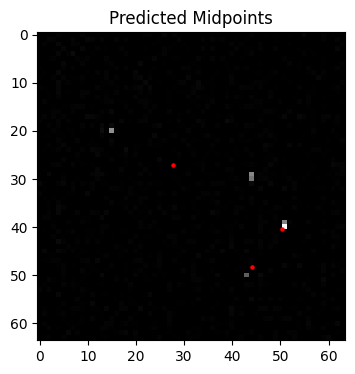

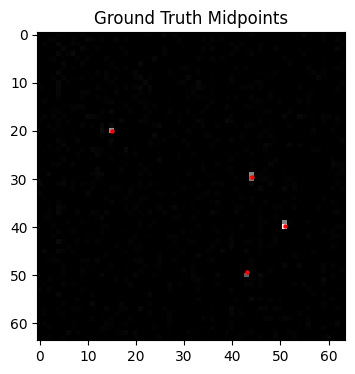

In [41]:

# Select an index to visualize from the entire dataset
index_to_visualize = np.random.randint(0, len(all_images))

# index_to_visualize = 11548
# Visualize the selected image with predicted and true midpoints
visualize_midpoints(all_images[index_to_visualize], all_pred_midpoints[index_to_visualize, 0, :, :] * 64, title="Predicted Midpoints")
visualize_midpoints(all_images[index_to_visualize], all_true_midpoints[index_to_visualize, 0, :, :] * 64, title="Ground Truth Midpoints")


code to visualize Josh's edit

In [45]:
# model_builder.model.save('/home/da886/Electron Counting Extended Arch/Overfitted weights/increased_model_Padded_weights.keras')

In [268]:
val_loss = model_builder.model.evaluate(val_dataset)

30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - loss: 0.0136


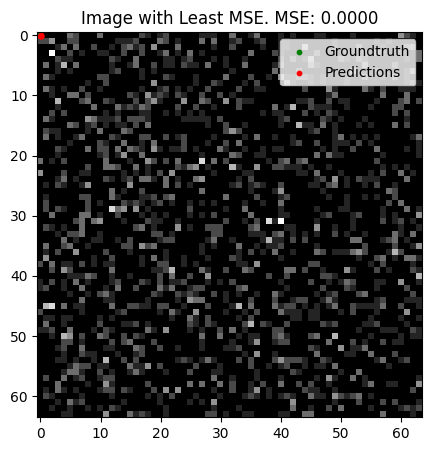

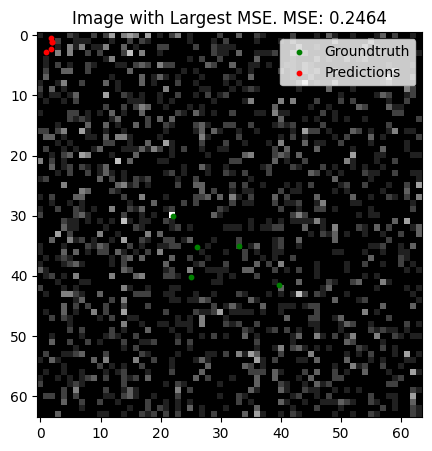

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables to track the min and max MSE
min_mse = float('inf')
max_mse = float('-inf')
min_mse_index = -1
max_mse_index = -1

# Loop through each prediction to calculate the MSE
for i in range(len(all_pred_midpoints)):
    mse = np.mean((all_pred_midpoints[i] - all_true_midpoints[i]) ** 2)
    
    if mse < min_mse:
        min_mse = mse
        min_mse_index = i
    
    if mse > max_mse:
        max_mse = mse
        max_mse_index = i
import numpy as np
import matplotlib.pyplot as plt

# Function to plot an image with its centers
def plot_image_with_centers(image, true_center, predicted_center, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')  # Display the image

    # Plot the actual center (Groundtruth)
    plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

    # Plot the predicted center
    plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

    plt.title(title)
    plt.legend()
    plt.show()






# Plotting the image with the least MSE
plot_image_with_centers(all_images[min_mse_index],
                        all_true_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Least MSE. MSE: {min_mse:.4f}')

# Plotting the image with the largest MSE
plot_image_with_centers(all_images[max_mse_index],
                        all_true_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Largest MSE. MSE: {max_mse:.4f}')


